# Inference pipeline

In [9]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [10]:
#export 
from xview2comp.nb_03 import *

### Pre-disaster and post-disaster image file paths

In [11]:
SOURCE = Path('data/test/images')
SOURCE.ls()[:3]

[PosixPath('data/test/images/test_pre_00831.png'),
 PosixPath('data/test/images/test_post_00171.png'),
 PosixPath('data/test/images/test_pre_00064.png')]

In [12]:
preimgs = pre_img_fpaths(get_image_files(SOURCE))

In [13]:
posimgs = [pre2post_fpath(o) for o in preimgs]

In [14]:
len(preimgs), len(posimgs)

(933, 933)

In [15]:
preimgs[:3]

[PosixPath('data/test/images/test_pre_00831.png'),
 PosixPath('data/test/images/test_pre_00064.png'),
 PosixPath('data/test/images/test_pre_00091.png')]

In [16]:
posimgs[:3]

[PosixPath('data/test/images/test_post_00831.png'),
 PosixPath('data/test/images/test_post_00064.png'),
 PosixPath('data/test/images/test_post_00091.png')]

### Building detection

In [17]:
#seglearn = load_learner('./', file='building_detector.pkl', test=SegItemListCustom(preimgs), tfm_y=False)
seglearn = load_learner('./', file='building_detector.pkl')

In [18]:
#y_mask, pred_mask, raw_pred_mask = seglearn.get_preds(ds_type=DatasetType.Test)

In [19]:
idx = 117

#idx = 67 #all undamaged  
#idx = 34 #no features

In [20]:
img = open_image(preimgs[idx])
print(preimgs[idx])

data/test/images/test_pre_00290.png


In [21]:
%%time
y_mask, pred_mask, raw_pred_mask = seglearn.predict(img)

CPU times: user 992 ms, sys: 148 ms, total: 1.14 s
Wall time: 1.18 s


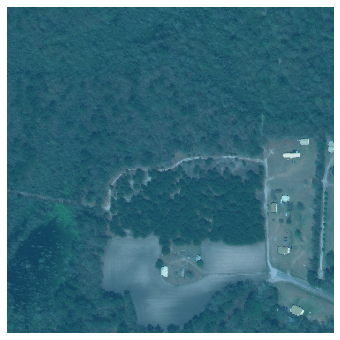

In [22]:
_, ax = plt.subplots(figsize=(6, 6))
img.show(ax)
y_mask.show(ax, alpha=.5)

### Building mask -> polygons

In [23]:
_, polys = bmask2polys(y_mask.data[0].numpy())

In [24]:
type(polys), len(polys)

(numpy.ndarray, 12)

### Generate unique ids for polygons

In [25]:
#export
def generate_uid_polys(polys): return np.array([str(uuid4()) for _ in polys])

In [26]:
uids = generate_uid_polys(polys)

### Get polygon images

In [27]:
path = Path('tmp_polyimgs')

In [28]:
shutil.rmtree(path, ignore_errors=True)
os.makedirs(path, exist_ok=True)

In [29]:
img = open_image(posimgs[idx])

In [30]:
for uid, p in zip(uids, polys):
    polyimg = crop_by_polygon(img, p)
    polyimg.save(path/f'{uid}.png')

Refactor into function.

In [31]:
#export
def polyimgs2disk(img, polys, path=None):
    if path is None: path = Path('tmp_polyimgs')
    shutil.rmtree(path, ignore_errors=True); os.makedirs(path, exist_ok=True)
    if len(polys) == 0: return path, []
    uids = generate_uid_polys(polys)
    for uid, p in zip(uids, polys): crop_by_polygon(img, p).save(path/f'{uid}.png')
    return path, uids

In [32]:
path, uids = polyimgs2disk(img, polys, path)

In [33]:
len(path.ls()), len(uids)

(12, 12)

### Damage classification

In [34]:
%%time
il = ImageList([path/f'{uid}.png' for uid in uids])
damglearn = load_learner('./', file='damage_classifier.pkl', test=il)

CPU times: user 116 ms, sys: 68 ms, total: 184 ms
Wall time: 145 ms


In [35]:
len(il.items)

12

In [36]:
%%time
pred_damg, y_damg = damglearn.get_preds(ds_type=DatasetType.Test)

CPU times: user 104 ms, sys: 232 ms, total: 336 ms
Wall time: 588 ms


In [37]:
pred_classes = [damglearn.data.classes[i] for i in pred_damg.argmax(dim=1)]

In [38]:
pred_classes[3], pred_damg[3] #, y_damg[3], y_damg.sum()

('no-damage/un-classified',
 tensor([9.9097e-01, 5.1195e-04, 6.1953e-03, 2.3228e-03]))

In [39]:
len(pred_classes), len(uids), len(polys), img

(12, 12, 12, Image (3, 1024, 1024))

Refactor into function.

In [40]:
#export
def assess_damage_polyimgs(polyimgs, path='./', file='./damage_classifier.pkl'):
    if len(polyimgs.items) == 0: return [] # Need `.items` because `len(ImageList)` is 1 for empty list.
    damglearn = load_learner(path, file, test=polyimgs)
    pred_damg, _ = damglearn.get_preds(ds_type=DatasetType.Test)
    return [damglearn.data.classes[o] for o in pred_damg.argmax(dim=1)]

In [41]:
polyimgs = ImageList([path/f'{uid}.png' for uid in uids])
damgs = assess_damage_polyimgs(polyimgs)

In [42]:
damgs[3], len(damgs)

('no-damage/un-classified', 12)

### Damage mask

In [43]:
DAMG_OTOI = {damg:i + 1 for i, damg in enumerate(damglearn.data.classes)}

In [44]:
DAMG_OTOI

{'no-damage/un-classified': 1,
 'minor-damage': 2,
 'major-damage': 3,
 'destroyed': 4}

In [45]:
damgmask = np.zeros(img.shape[1:], dtype=np.uint8)

In [46]:
for damg, poly in zip(damgs, polys):
    cv2.fillPoly(damgmask, poly[None,...], (DAMG_OTOI[damg]))
    
damgmask = ImageSegment(tensor(damgmask[None,...]))

Refactor into function.

In [47]:
#export
def damgpolys2damgmask(polys, damgs, sz=1024):
    assert len(polys) == len(damgs)
    if isinstance(sz, int): sz = (sz, sz)
    mask = np.zeros(sz, dtype=np.uint8)
    if len(polys) > 0:
        for damg, poly in zip(damgs, polys): 
            cv2.fillPoly(mask, poly[None,...], (DAMG_OTOI[damg]))
    return ImageSegment(tensor(mask[None,...]))

In [48]:
damgmask = damgpolys2damgmask(polys, damgs, img.shape[1:])

In [49]:
damgmask.data.unique()

tensor([0, 1, 3])

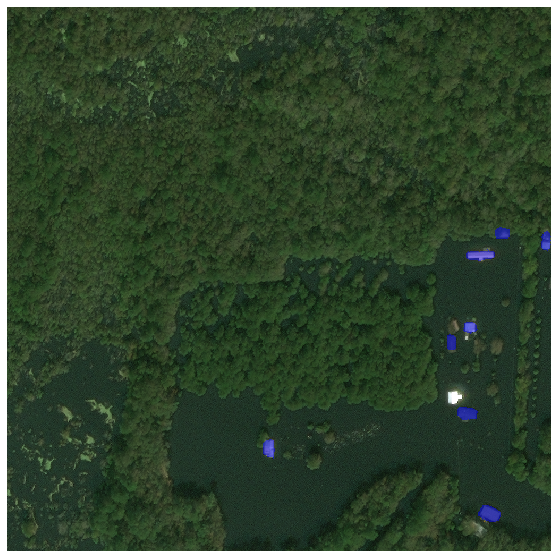

In [51]:
_, ax = plt.subplots(figsize=(10, 10))
img.show(ax)
damgmask.show(ax, alpha=.5, cmap=CMAP, vmax=4)

### Pipeline

In [52]:
#export
def infer_sample(path_preimg, path_posimg, seglearn, path_damglearn='./damage_classifier.pkl'):
    img = open_image(path_preimg)
    y_mask, _, _ = seglearn.predict(img)
    _, polys = bmask2polys(y_mask.data[0].numpy())
    img = open_image(path_posimg)
    path, uids = polyimgs2disk(img, polys, path=Path('tmp_polyimgs'))
    polyimgs = ImageList([path/f'{uid}.png' for uid in uids])
    damgs = assess_damage_polyimgs(polyimgs, file=path_damglearn)
    damgmask = damgpolys2damgmask(polys, damgs, sz=img.shape[1:])
    return damgmask

def get_imgid(imgname): return imgname.stem.split('_')[-1]

In [53]:
path_results = Path('./inference_results')

In [54]:
os.makedirs(path_results, exist_ok=True)

In [65]:
idx = 332
damgmask = infer_sample(preimgs[idx], posimgs[idx], seglearn, 'damage_classifier.pkl')

tensor([0, 1, 3, 4])

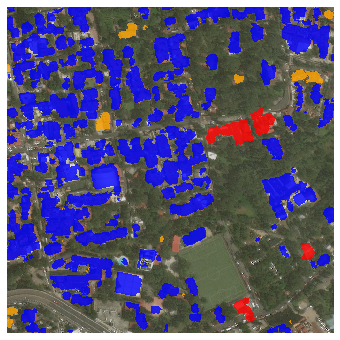

In [67]:
_, ax = plt.subplots(figsize=(6, 6))
open_image(posimgs[idx]).show(ax)
damgmask.show(ax, alpha=.8, cmap=CMAP, vmax=len(CMAP.colors)-1)
damgmask.data.unique()

Takes about 40 minutes to generate the inference .pngs for the entire test set.

In [70]:
for idx in progress_bar(range(len(preimgs))):
    npre, npos = preimgs[idx], posimgs[idx]
    damgmask = infer_sample(npre, npos, seglearn, 'damage_classifier.pkl')
    imgid = get_imgid(npre)
    damgmask.save(path_results/f'test_localization_{imgid}_prediction.png')
    damgmask.save(path_results/f'test_damage_{imgid}_prediction.png')

In [100]:
print(len(get_image_files(path_results)))
get_image_files(path_results)[:5]

1866


[PosixPath('inference_results/test_localization_00536_prediction.png'),
 PosixPath('inference_results/test_damage_00313_prediction.png'),
 PosixPath('inference_results/test_damage_00142_prediction.png'),
 PosixPath('inference_results/test_localization_00376_prediction.png'),
 PosixPath('inference_results/test_damage_00919_prediction.png')]

In [95]:
# imgid = get_imgid(preimgs[332]) Lots of buildings [0, 1, 3, 4]
# imgid = '00064'  no buildings


In [96]:
path_local = path_results/f'test_localization_{imgid}_prediction.png'
path_damg = path_results/f'test_damage_{imgid}_prediction.png'

In [97]:
mask_local, mask_damg = open_mask(path_local), open_mask(path_damg)

In [98]:
mask_local.data.unique(), mask_damg.data.unique()

(tensor([0, 1, 3, 4]), tensor([0, 1, 3, 4]))

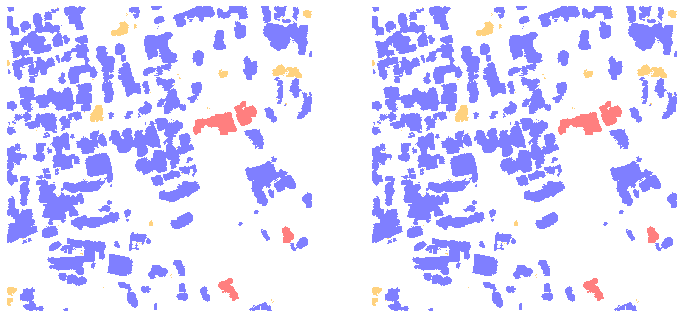

In [99]:
_, axs = plt.subplots(ncols=2, figsize=(12, 6))
open_mask(path_local).show(axs[0], cmap=CMAP, vmax=len(CMAP.colors) - 1)
open_mask(path_damg).show(axs[1], cmap=CMAP, vmax=len(CMAP.colors) - 1)

In [101]:
! tar czvf inference_results.tar.gz {path_results}

inference_results/
inference_results/test_localization_00536_prediction.png
inference_results/test_damage_00313_prediction.png
inference_results/test_damage_00142_prediction.png
inference_results/test_localization_00376_prediction.png
inference_results/test_damage_00919_prediction.png
inference_results/test_localization_00111_prediction.png
inference_results/test_localization_00065_prediction.png
inference_results/test_damage_00620_prediction.png
inference_results/test_localization_00315_prediction.png
inference_results/test_localization_00206_prediction.png
inference_results/test_localization_00556_prediction.png
inference_results/test_localization_00789_prediction.png
inference_results/test_localization_00435_prediction.png
inference_results/test_localization_00931_prediction.png
inference_results/test_damage_00161_prediction.png
inference_results/test_localization_00506_prediction.png
inference_results/test_localization_00501_prediction.png
inference_results/test_localization_00621_

inference_results/test_localization_00346_prediction.png
inference_results/test_damage_00360_prediction.png
inference_results/test_localization_00255_prediction.png
inference_results/test_localization_00054_prediction.png
inference_results/test_localization_00142_prediction.png
inference_results/test_damage_00669_prediction.png
inference_results/test_localization_00738_prediction.png
inference_results/test_localization_00620_prediction.png
inference_results/test_damage_00621_prediction.png
inference_results/test_localization_00802_prediction.png
inference_results/test_damage_00653_prediction.png
inference_results/test_localization_00399_prediction.png
inference_results/test_localization_00875_prediction.png
inference_results/test_damage_00543_prediction.png
inference_results/test_localization_00647_prediction.png
inference_results/test_localization_00423_prediction.png
inference_results/test_damage_00744_prediction.png
inference_results/test_localization_00606_prediction.png
inference_

inference_results/test_localization_00203_prediction.png
inference_results/test_damage_00844_prediction.png
inference_results/test_localization_00229_prediction.png
inference_results/test_localization_00869_prediction.png
inference_results/test_damage_00082_prediction.png
inference_results/test_damage_00482_prediction.png
inference_results/test_damage_00851_prediction.png
inference_results/test_localization_00064_prediction.png
inference_results/test_damage_00051_prediction.png
inference_results/test_damage_00649_prediction.png
inference_results/test_localization_00839_prediction.png
inference_results/test_localization_00180_prediction.png
inference_results/test_localization_00631_prediction.png
inference_results/test_localization_00438_prediction.png
inference_results/test_localization_00726_prediction.png
inference_results/test_damage_00476_prediction.png
inference_results/test_damage_00153_prediction.png
inference_results/test_localization_00782_prediction.png
inference_results/test

inference_results/test_localization_00883_prediction.png
inference_results/test_localization_00359_prediction.png
inference_results/test_localization_00637_prediction.png
inference_results/test_localization_00730_prediction.png
inference_results/test_localization_00543_prediction.png
inference_results/test_damage_00612_prediction.png
inference_results/test_damage_00192_prediction.png
inference_results/test_damage_00434_prediction.png
inference_results/test_localization_00290_prediction.png
inference_results/test_damage_00129_prediction.png
inference_results/test_localization_00773_prediction.png
inference_results/test_localization_00491_prediction.png
inference_results/test_damage_00105_prediction.png
inference_results/test_damage_00714_prediction.png
inference_results/test_localization_00177_prediction.png
inference_results/test_localization_00922_prediction.png
inference_results/test_localization_00034_prediction.png
inference_results/test_localization_00685_prediction.png
inference_

inference_results/test_localization_00719_prediction.png
inference_results/test_localization_00694_prediction.png
inference_results/test_damage_00221_prediction.png
inference_results/test_damage_00923_prediction.png
inference_results/test_damage_00211_prediction.png
inference_results/test_damage_00899_prediction.png
inference_results/test_damage_00278_prediction.png
inference_results/test_damage_00743_prediction.png
inference_results/test_localization_00403_prediction.png
inference_results/test_damage_00495_prediction.png
inference_results/test_damage_00637_prediction.png
inference_results/test_localization_00610_prediction.png
inference_results/test_damage_00402_prediction.png
inference_results/test_damage_00932_prediction.png
inference_results/test_localization_00482_prediction.png
inference_results/test_damage_00406_prediction.png
inference_results/test_localization_00701_prediction.png
inference_results/test_damage_00233_prediction.png
inference_results/test_localization_00505_pred

inference_results/test_localization_00891_prediction.png
inference_results/test_localization_00130_prediction.png
inference_results/test_localization_00786_prediction.png
inference_results/test_damage_00735_prediction.png
inference_results/test_localization_00246_prediction.png
inference_results/test_damage_00564_prediction.png
inference_results/test_damage_00392_prediction.png
inference_results/test_damage_00342_prediction.png
inference_results/test_localization_00573_prediction.png
inference_results/test_damage_00779_prediction.png
inference_results/test_damage_00592_prediction.png
inference_results/test_localization_00385_prediction.png
inference_results/test_damage_00252_prediction.png
inference_results/test_damage_00140_prediction.png
inference_results/test_localization_00558_prediction.png
inference_results/test_localization_00083_prediction.png
inference_results/test_damage_00718_prediction.png
inference_results/test_damage_00815_prediction.png
inference_results/test_damage_0091

inference_results/test_localization_00067_prediction.png
inference_results/test_localization_00178_prediction.png
inference_results/test_damage_00622_prediction.png
inference_results/test_damage_00523_prediction.png
inference_results/test_damage_00667_prediction.png
inference_results/test_localization_00424_prediction.png
inference_results/test_localization_00570_prediction.png
inference_results/test_damage_00443_prediction.png
inference_results/test_localization_00266_prediction.png
inference_results/test_localization_00228_prediction.png
inference_results/test_damage_00196_prediction.png
inference_results/test_localization_00820_prediction.png
inference_results/test_damage_00369_prediction.png
inference_results/test_damage_00230_prediction.png
inference_results/test_damage_00769_prediction.png
inference_results/test_localization_00154_prediction.png
inference_results/test_localization_00548_prediction.png
inference_results/test_localization_00710_prediction.png
inference_results/test

inference_results/test_localization_00715_prediction.png
inference_results/test_localization_00639_prediction.png
inference_results/test_localization_00810_prediction.png
inference_results/test_localization_00289_prediction.png
inference_results/test_localization_00314_prediction.png
inference_results/test_damage_00400_prediction.png
inference_results/test_damage_00551_prediction.png
inference_results/test_damage_00246_prediction.png
inference_results/test_localization_00756_prediction.png
inference_results/test_localization_00015_prediction.png
inference_results/test_localization_00619_prediction.png
inference_results/test_localization_00277_prediction.png
inference_results/test_damage_00915_prediction.png
inference_results/test_damage_00339_prediction.png
inference_results/test_localization_00460_prediction.png
inference_results/test_damage_00135_prediction.png
inference_results/test_damage_00508_prediction.png
inference_results/test_damage_00553_prediction.png
inference_results/test

inference_results/test_localization_00348_prediction.png
inference_results/test_damage_00378_prediction.png
inference_results/test_localization_00149_prediction.png
inference_results/test_damage_00574_prediction.png
inference_results/test_damage_00226_prediction.png
inference_results/test_damage_00742_prediction.png
inference_results/test_damage_00567_prediction.png
inference_results/test_localization_00744_prediction.png
inference_results/test_damage_00632_prediction.png
inference_results/test_damage_00501_prediction.png
inference_results/test_localization_00416_prediction.png
inference_results/test_damage_00684_prediction.png
inference_results/test_damage_00187_prediction.png
inference_results/test_localization_00829_prediction.png
inference_results/test_damage_00752_prediction.png
inference_results/test_localization_00674_prediction.png
inference_results/test_localization_00367_prediction.png
inference_results/test_localization_00600_prediction.png
inference_results/test_damage_0021

inference_results/test_damage_00782_prediction.png
inference_results/test_localization_00484_prediction.png
inference_results/test_localization_00123_prediction.png
inference_results/test_damage_00643_prediction.png
inference_results/test_damage_00195_prediction.png
inference_results/test_damage_00751_prediction.png
inference_results/test_localization_00521_prediction.png
inference_results/test_localization_00634_prediction.png
inference_results/test_localization_00837_prediction.png
inference_results/test_damage_00040_prediction.png
inference_results/test_localization_00867_prediction.png
inference_results/test_damage_00430_prediction.png
inference_results/test_damage_00453_prediction.png
inference_results/test_damage_00624_prediction.png
inference_results/test_localization_00550_prediction.png
inference_results/test_damage_00843_prediction.png
inference_results/test_localization_00547_prediction.png
inference_results/test_localization_00463_prediction.png
inference_results/test_damag

In [102]:
! du -hs inference_results*

17M	inference_results
12M	inference_results.tar.gz


# - fin

In [103]:
! python notebook2script.py 03b_inference_pipeline.ipynb

Converted 03b_inference_pipeline.ipynb to xview2comp/nb_03b.py
